In [1]:
import sys
sys.path.append('../')

import os

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.ledger.ledger as ledger
import cqt.datagen as dg
import cqt.dbutility.dbutility as db
import cqt.strats.strategy as stg
import cqt.strats.strategy_long_short_average as stg_ls
import pandas as pd
import pickle

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import copy
import cqt.strats.StrategyTensorFlow as stg_tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### db.get_table_list() method takes 1 argument db_id, and is defaulted to 'Amazon_RDS'
df_tbl_list=db.get_table_list()
print(df_tbl_list)

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


                                   table_name
0    coinapi-ohlcv-BINANCE_SPOT_BTC_USDT-1DAY
1    coinapi-ohlcv-BINANCE_SPOT_ETH_USDT-1DAY
2    coinapi-ohlcv-COINBASE_SPOT_LTC_USD-1DAY
3    coinapi-ohlcv-BINANCE_SPOT_ADA_USDT-1DAY
4         coinapi-ohlcv-DSX_SPOT_ETH_USD-1DAY
5      coinapi-ohlcv-KRAKEN_SPOT_XLM_USD-1DAY
6         coinapi-ohlcv-DSX_SPOT_LTC_USD-1DAY
7   coinapi-ohlcv-BINANCE_SPOT_IOTA_USDT-1DAY
8      coinapi-ohlcv-GEMINI_SPOT_BTC_USD-1DAY
9    coinapi-ohlcv-BINANCE_SPOT_EOS_USDT-1DAY
10        coinapi-ohlcv-DSX_SPOT_BCH_USD-1DAY
11     coinapi-ohlcv-KRAKEN_SPOT_EOS_USD-1DAY
12     coinapi-ohlcv-KRAKEN_SPOT_BCH_USD-1DAY
13     coinapi-ohlcv-KRAKEN_SPOT_XRP_USD-1DAY
14   coinapi-ohlcv-BINANCE_SPOT_LTC_USDT-1DAY
15   coinapi-ohlcv-COINBASE_SPOT_BTC_USD-1DAY
16   coinapi-ohlcv-BINANCE_SPOT_BCH_USDT-1DAY
17     coinapi-ohlcv-GEMINI_SPOT_ETH_USD-1DAY
18   coinapi-ohlcv-BINANCE_SPOT_XRP_USDT-1DAY
19     coinapi-ohlcv-KRAKEN_SPOT_ETH_USD-1DAY
20   coinapi-ohlcv-COINBASE_SPOT_B

In [2]:
TODAY = datetime.now()

tbl_name='coinapi-ohlcv-COINBASE_SPOT_BTC_USD-1DAY'
df_btc=db.get_from_db(tbl_name,from_date='2016-01-01',to_date=TODAY.strftime('%Y-%M-%d'))
#df_eth = db.get_from_db("coinapi-ohlcv-COINBASE_SPOT_ETH_USD-1DAY",from_date='2016-01-01',to_date=TODAY.strftime('%Y-%M-%d'))



/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
config = {'asset_type': 'spot'}
model_btc_eth = env.MktEnv([])
comp_btc = envspot.MktEnvSpot('btc', df_btc.get_index_data(), config)
model_btc_eth.insert_section(comp_btc)



cash = 10000
assets = {'btc': 0}
ini_pfo = ledger.Ledger(assets, cash)


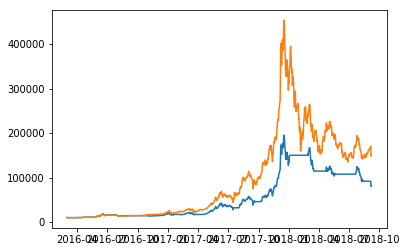

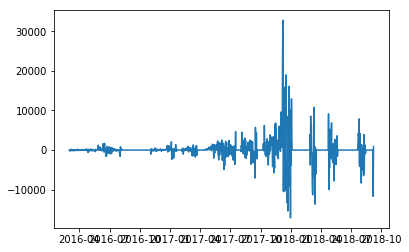

In [16]:
# Long/Short Average
ls_rule = {'method' : 'moving_average', 'window_size' : [15, 30], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_ls.StrategyInverseMA(model_btc_eth, ini_pfo, ls_rule)
start_date_str = '2016-03-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

longShortReport = report.copy()

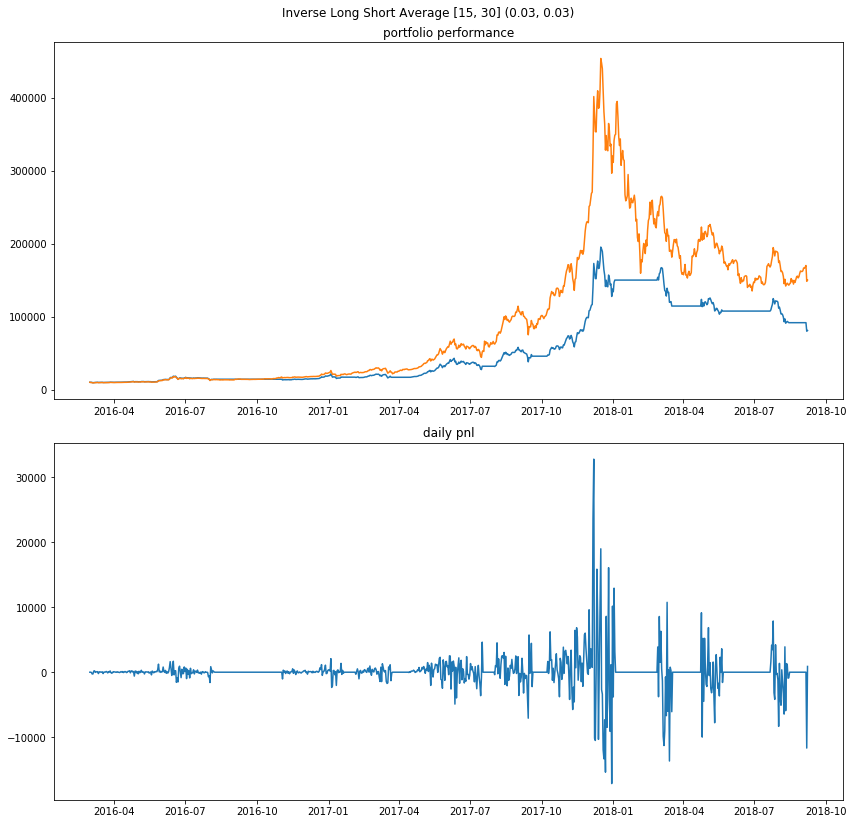

max daily gain: 32793.17132953234
max daily loss: -17142.429305887883


In [17]:
report = longShortReport
outDir='./'

strategyName = 'Inverse Long Short Average [15, 30] (0.03, 0.03)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())


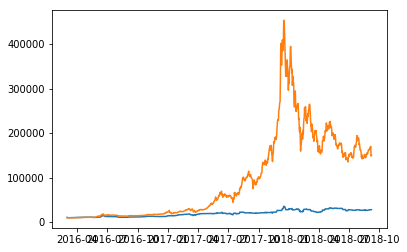

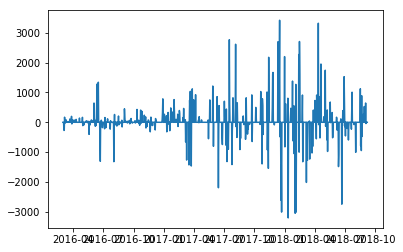

In [19]:
import cqt.strats.strategy_double_dip as stg_dd

# Double Dip Strategy
dd_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_dd.StrategyDoubleDip(model_btc_eth, ini_pfo, dd_rule)
start_date_str = '2016-03-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)


In [20]:
report

,date,total,pnl,cash,set_aside,btc_holding,btc_price
0,2016-03-01,10000.000000,0,10000,0.0,0,433.08
1,2016-03-02,10000.000000,0,10000,0.0,0,420.39
2,2016-03-03,10000.000000,0,0,0.0,23.8777,418.80
3,2016-03-04,9726.599809,-273.4,0,0.0,23.8777,407.35
4,2016-03-05,9457.497612,-269.102,0,0.0,23.8777,396.08
5,2016-03-06,9628.462273,170.965,9628.46,0.0,0,403.24
6,2016-03-07,9628.462273,0,0,0.0,23.3581,412.21
7,2016-03-08,9604.403381,-24.0589,9604.4,0.0,0,411.18
8,2016-03-09,9604.403381,0,9604.4,0.0,0,412.80
9,2016-03-10,9604.403381,0,0,0.0,23.0886,415.98


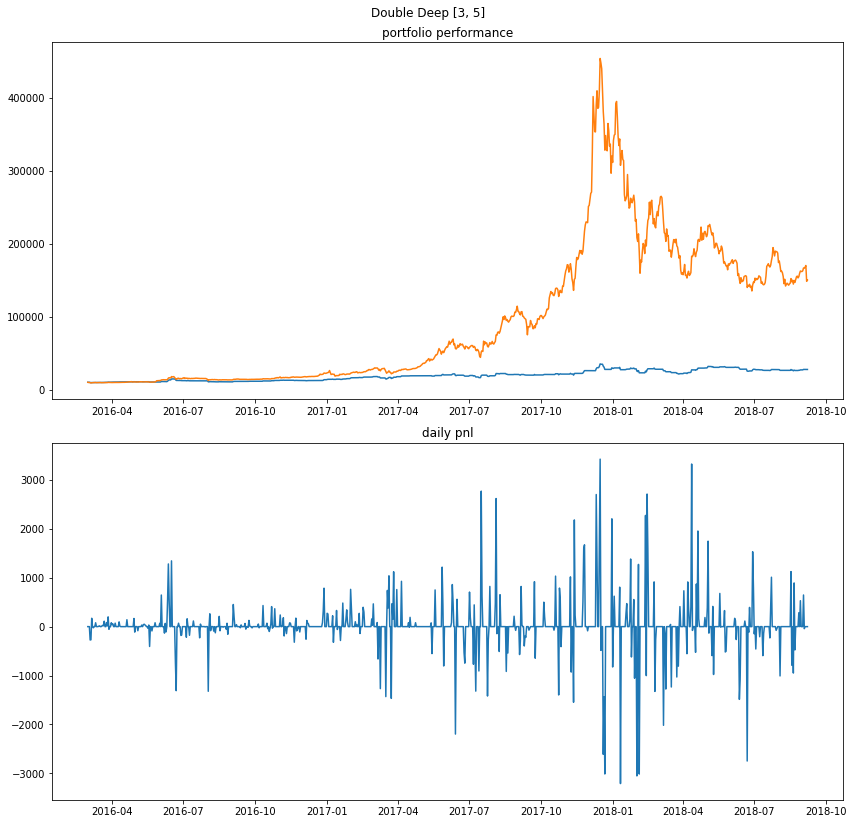

max daily gain: 3423.4190105749767
max daily loss: -3208.374847257266


In [21]:
strategyName = 'Double Deep [3, 5]'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())

In [13]:
from talib.abstract import *
import copy
prices = copy.deepcopy(comp_btc.data)
prices.rename(columns={'price_open': 'open', 'price_high': 'high', 'price_low': 'low', 'price_close': 'close', 'volume_traded': 'volume'}, inplace=True)
close = prices['close'].values
sma15 = SMA(prices, timeperiod=15)
sma60 = SMA(prices, timeperiod=60)
rsi = RSI(prices, timeperiod=14)
atr = ATR(prices, timeperiod=14)


In [17]:
-atr[100]

-6.534930473168205

In [8]:
import numpy
import talib

close = prices['close'].values

from talib import MA_Type

upper, middle, lower = talib.BBANDS(close, matype=MA_Type.T3)


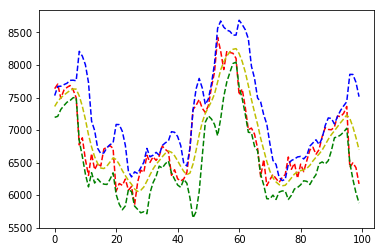

In [9]:
plt.plot(close[-100:],  'r--',upper[-100:],'b--',middle[-100:], 'y--', lower[-100:], 'g--')
plt.show()

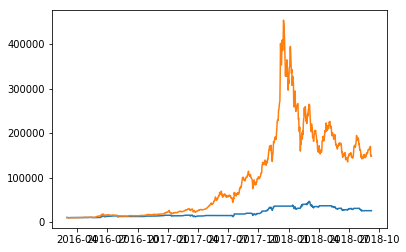

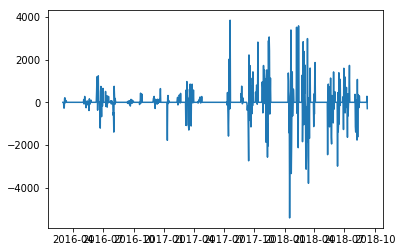

In [4]:
import cqt.strats.StrategyBBANDS as stg_bb

# B BANDS Strategy
dd_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_bb.StrategyBBANDS(model_btc_eth, ini_pfo, dd_rule)
start_date_str = '2016-03-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

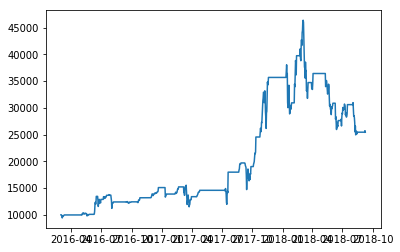

In [13]:
plt.plot(report['date'],report['total'])

In [11]:
report[-10:]

,date,total,pnl,cash,set_aside,btc_holding,btc_price
912,2018-08-30,39735.497980,-153.972,0,0.0,5.66907,7009.18
913,2018-08-31,39709.476971,-26.021,0,0.0,5.66907,7004.59
914,2018-09-01,39950.015405,240.538,0,0.0,5.66907,7047.02
915,2018-09-02,40907.803960,957.789,0,0.0,5.66907,7215.97
916,2018-09-03,40845.614316,-62.1896,0,0.0,5.66907,7205.00
917,2018-09-04,41143.920523,298.306,0,0.0,5.66907,7257.62
918,2018-09-05,41741.326607,597.406,0,0.0,5.66907,7363.00
919,2018-09-06,36423.686818,-5317.64,0,0.0,5.66907,6424.99
920,2018-09-07,36827.154184,403.467,0,0.0,5.66907,6496.16
921,2018-09-08,36404.298615,-422.856,0,0.0,5.66907,6421.57


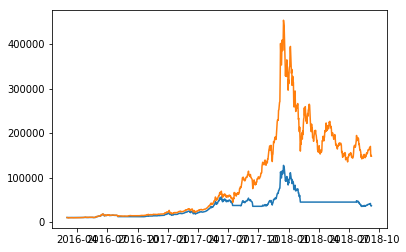

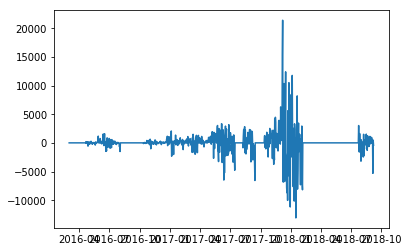

In [10]:
import cqt.strats.StrategyRSI as stg_rsi

# RSI Strategy
rsi_rule = {'method' : 'RSI'}
strats = stg_rsi.StrategyRSI(model_btc_eth, ini_pfo, rsi_rule)
start_date_str = '2016-03-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

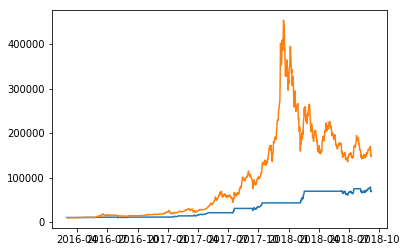

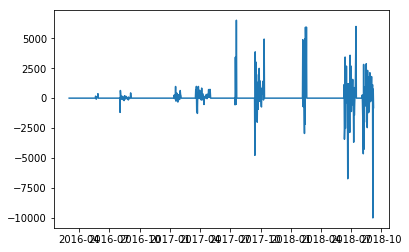

In [8]:
import cqt.strats.StrategyATR as stg_atr

# ATR Strategy
atr_rule = {'method' : 'ATR','bandwidth':[-2,2]}
strats = stg_atr.StrategyATR(model_btc_eth, ini_pfo, atr_rule)
start_date_str = '2016-03-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

In [9]:
report[-10:]

,date,total,pnl,cash,set_aside,btc_holding,btc_price
912,2018-08-30,74825.752435,-289.944,0,0.0,10.6754,7009.18
913,2018-08-31,74776.752381,-49.0001,0,0.0,10.6754,7004.59
914,2018-09-01,75229.709314,452.957,0,0.0,10.6754,7047.02
915,2018-09-02,77033.316993,1803.61,0,0.0,10.6754,7215.97
916,2018-09-03,76916.207930,-117.109,0,0.0,10.6754,7205.00
917,2018-09-04,77477.947119,561.739,0,0.0,10.6754,7257.62
918,2018-09-05,78602.920054,1124.97,0,0.0,10.6754,7363.00
919,2018-09-06,68589.294488,-10013.6,0,0.0,10.6754,6424.99
920,2018-09-07,69349.062221,759.768,0,0.0,10.6754,6496.16
921,2018-09-08,68552.784643,-796.278,0,0.0,10.6754,6421.57
